In [0]:
import h5py
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
import tensorflow as tf

from google.colab import drive
from functools import partial
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy

sns.set()
warnings.filterwarnings("ignore")
drive.mount('/content/drive/')
print (tf.test.gpu_device_name())

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/



# Data Preprocessing

**Data Preview**

In [0]:
"""
df = pd.read_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv")
df = df.iloc[:, 1:]
df.iloc[:, 1] = df.iloc[:, 1] / 2 # To simulate PV penetration
df.iloc[:, 2] = df.iloc[:, 2] / 100 # Convert to $/kWh
df.columns = ["PV (kWh)", "Load (kWh)", "Price ($/kWh)"]
df.to_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv", index = False)
df.head(24)
"""

'\ndf = pd.read_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv")\ndf = df.iloc[:, 1:]\ndf.iloc[:, 1] = df.iloc[:, 1] / 2 # To simulate PV penetration\ndf.iloc[:, 2] = df.iloc[:, 2] / 100 # Convert to $/kWh\ndf.columns = ["PV (kWh)", "Load (kWh)", "Price ($/kWh)"]\ndf.to_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv", index = False)\ndf.head(24)\n'

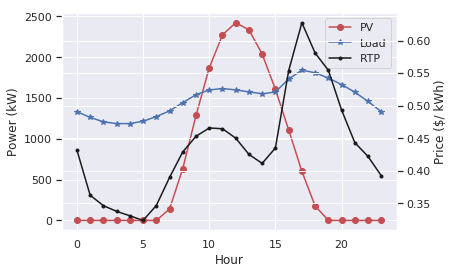

In [0]:
df_raw = pd.read_csv("/content/drive/My Drive/Colab/Research - Transactive Energy/Final Modified Data.csv")
df = df_raw.copy()

fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

PV_plot = ax.plot(df.iloc[0:24, 0], 'ro-', label = "PV")
load_plot = ax.plot(df.iloc[0:24, 1], 'b*-', label = "Load")
price_plot = ax2.plot(df.iloc[0:24, 2], 'k.-', label = "RTP")

# Show all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)

ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

**Standardization**

In [0]:
# StandardScaler

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean = False)
price = sc_price.fit_transform(df.iloc[:, 2:].values)

sc_energy = StandardScaler(with_mean = False)
pv = sc_energy.fit_transform(df.iloc[:, 0:1].values)
load = sc_energy.transform(df.iloc[:, 1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

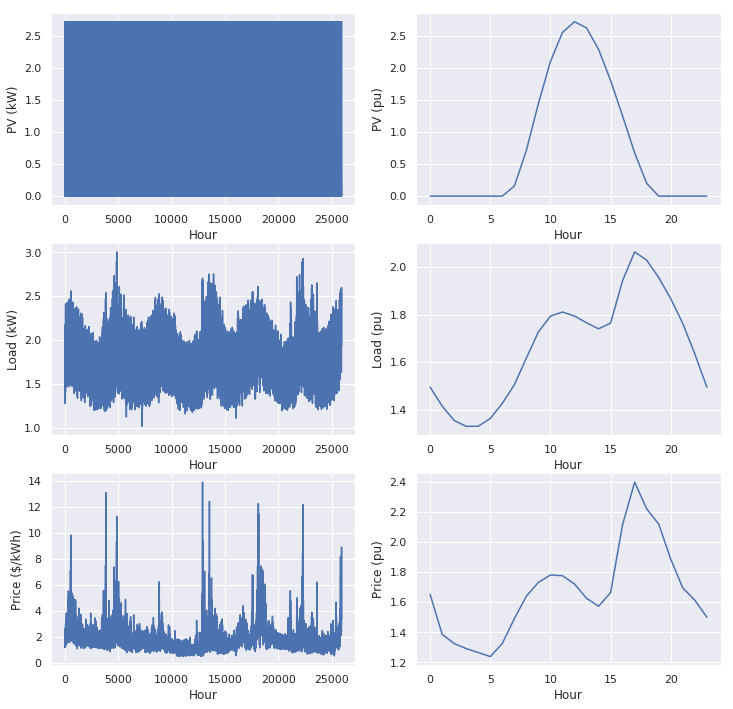

In [0]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))

ax[0, 0].plot(x[:, 0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")

ax[0, 1].plot(x[0:24, 0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].plot(x[:, 1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")

ax[1, 1].plot(x[0:24, 1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].plot(x[:, 2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")

ax[2, 1].plot(x[0:24, 2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")
plt.show()

# Model

**A2C Policy Model**

In [0]:
class A2CAgent:
  
  def __init__(self, state_size, action_size):

    self.load_model = False
    self.state_size = state_size
    self.action_size = action_size
    self.value_size = 1
    self.actor_lr = 0.00005
    self.critic_lr = 0.001
    self.gamma = 0.95

    # Create model for actor and critic network
    self.actor, self.critic = self.build_model()

    # Method for training actor and critic network
    self.optimizer = [self.actor_optimizer(), self.critic_optimizer()]

    if self.load_model:
      drive.mount('/content/drive/')
      agent.actor.load_weights("/content/drive/My Drive/Colab/Research - Transactive Energy/4. 20191008_Actor.hdf5")
      agent.critic.load_weights("/content/drive/My Drive/Colab/Research - Transactive Energy/4. 20191008_Critic.hdf5")

  def build_model(self):
    
    state = Input(shape = (self.state_size, ))
    actor_input = Dense(30, activation = 'relu', \
                        kernel_initializer = 'he_uniform')(state)
    actor_hidden = Dense(60, activation = 'relu')(actor_input)
    mu_0 = Dense(self.action_size, activation = 'tanh', \
                 kernel_initializer = 'he_uniform')(actor_hidden)
    sigma_sq_0 = Dense(self.action_size, activation = 'softplus', \
                    kernel_initializer = 'he_uniform')(actor_hidden)

    mu = Lambda(lambda x: x * 1)(mu_0)
    sigma_sq = Lambda(lambda x: x + 0.01)(sigma_sq_0)

    critic_input = Dense(30, activation = 'relu', \
                         kernel_initializer = 'he_uniform')(state)
    critic_hidden = Dense(60, activation = 'relu')(critic_input)
    state_value = Dense(1, activation = 'linear', \
                        kernel_initializer = 'he_uniform')(critic_hidden)

    actor = Model(inputs = state, outputs = [mu, sigma_sq])
    critic = Model(inputs = state, outputs = state_value)

    actor._make_predict_function()
    critic._make_predict_function()

    actor.summary()
    critic.summary()

    return actor, critic

  # Make loss function for policy gradient
  def actor_optimizer(self):

    """
    1. In keras, multi-output models loss function is applied for each output 
       separately. In order to make use of all outputs in customized loss, 
       model._make_predict_function() is used to make use of model.output for 
       customization of loss function. (We need mu and sigma to compute probability)
    # https://stackoverflow.com/questions/44172165/keras-multiple-output-custom-loss-function
    # https://github.com/Hyeokreal/Actor-Critic-Continuous-Keras/blob/master/a2c_continuous.py
    
    2. Policy reinforcement learning loss function - gradient ascent
       J = J + lr * delta_J - gradient ascent -> loss function = -ve
       delta_J = -log(prob_action_taken) * advantage/ discounted_rewards
               = categorical_crossentropy(y_true, y_pred) * ''
    # https://gist.github.com/kkweon/c8d1caabaf7b43317bc8825c226045d2
    
    3. Action is the action moveset within [-1, 1]. The gaussian probability is
       computed with mu and sigma output from actor and policy gradient is updated

    """    
    
    actions = K.placeholder(shape = (None, 1))
    advantages = K.placeholder(shape = (None, 1))
    mu, sigma_sq = self.actor.output

    pdf = 1. / K.sqrt(2. * np.pi * sigma_sq) * K.exp(-K.square(actions - mu) / (2. * sigma_sq))
    log_pdf = K.log(pdf + K.epsilon())
    entropy = K.sum(0.5 * (K.log(2. * np.pi * sigma_sq) + 1.))
    exp_v = log_pdf * advantages
    exp_v = K.sum(exp_v + 0.01 * entropy)
    actor_loss = -exp_v

    optimizer = Adam(lr = self.actor_lr)
    updates = optimizer.get_updates(self.actor.trainable_weights, [], actor_loss)
    train = K.function([self.actor.input, actions, advantages], [], updates=updates)
    
    return train

  # Make loss function for Value approximation
  def critic_optimizer(self):
    
    discounted_reward = K.placeholder(shape = (None, 1))
    value = self.critic.output
    
    loss = K.mean(K.square(discounted_reward - value))

    optimizer = Adam(lr = self.critic_lr)
    updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
    train = K.function([self.critic.input, discounted_reward], [], updates=updates)
    
    return train

  # Using the output of policy network, pick action stochastically
  def get_action(self, state):
    
    mu, sigma_sq = self.actor.predict(np.reshape(state, [1, self.state_size]))
    epsilon = np.random.randn(self.action_size)
    action = mu + np.sqrt(sigma_sq) * epsilon
    action = np.clip(action, -1, 1) # within -1 and 1
    action = action.squeeze()
    
    return action

  # update policy network every episode
  def train_model(self, state, action, reward, next_state, done):
    
    state = np.reshape(state, [1, self.state_size])
    next_state = np.reshape(next_state, [1, self.state_size])
    action = np.reshape(action, [1, self.action_size])
    
    value = self.critic.predict(state)
    next_value = self.critic.predict(next_state)     
    advantages = reward + self.gamma * (next_value) - value
    target = reward + self.gamma * next_value
    
    self.optimizer[0]([state, action, advantages])
    self.optimizer[1]([state, target])

**Battery Model**

In [0]:
class Battery():
    
  def __init__(self, scaler_energy, scaler_price):
    
    """
    P_rated - charge/ discharge rate (kW)
    E_rated - rated capacity (kWh)
    C_E - energy capital cost ($/kWh)
    LC - life cycle
    eta - efficiency
    DOD - depth of discharge
    wear_cost - wear & operation cost ($/kWh/operation)
    wear_cost = (C_E * E_rated) / (eta * E_rated * LC * DOD)
    a1, m1, m2_c, m2_d: multiplier for energy gain
    """ 
    self.P_rated = scaler_energy.transform(np.array([[1000]]))[0] # pu
    self.E_rated = scaler_energy.transform(np.array([[5000]]))[0] # pu 
    self.C_E = scaler_price.transform(np.array([[171]]))[0] # pu
    self.LC = 4996
    self.eta = 1.
    self.DOD = 1.
    self.wear_cost = self.C_E / self.eta / self.DOD / self.LC
    self.initial_SOC = 0.
    self.target_SOC = 0.5 # Decide the backup energy required
    self.a1 = 4.
    self.m1 = 1.5
    self.m2_c = 0.9
    self.m2_d = 1.2
    self.m2_d2 = 1
    self.plot_multiplier()
    
  def compute(self, state, action):
    
    current_pv = state[0]
    current_load = state[1]
    current_price = state[2]
    current_SOC = state[3]
    average_price = state[4]
    
    delta_SOC = action * self.P_rated / self.E_rated
    
    if action <= 0:
      next_SOC = np.maximum(0., current_SOC + delta_SOC)
      # Assign penalty if battery operates exceeding permissible limit
      if abs(delta_SOC) > current_SOC:
        penalty = 10
      else:
        penalty = 0
    else:
      next_SOC = np.minimum(1., current_SOC + delta_SOC)
      if abs(delta_SOC) > 1 - current_SOC:
        penalty = 10
      else:
        penalty = 0
    
    # Assign penalty to force containment of PV within the building
    if current_pv > (current_load + (next_SOC - current_SOC) * self.E_rated):
      penalty2 = 10
    else:
      penalty2 = 0
    
    # Compute piecewise multiplier
    if next_SOC < self.target_SOC: # Before target SOC is met
      multiplier = 1 + self.a1 * np.exp(-(-np.log((self.m1 - 1) / self.a1)) * \
                                         next_SOC / self.target_SOC)      
    else: # After target SOC is met
      if delta_SOC >= 0: # Charge
        multiplier = np.exp(-(-np.log(self.m2_c)) * (next_SOC - self.target_SOC) \
                            / (1 - self.target_SOC))       
      else: # Discharge
        multiplier = self.m2_d * np.exp(-(-np.log(self.m2_d2 / self.m2_d)) * \
                                        (next_SOC - self.target_SOC) \
                                        / (1 - self.target_SOC))       

    # +ve - positive reward/ gain
    energy_gain = average_price * (next_SOC - current_SOC) * self.E_rated * multiplier
    trading_cost = current_price * (next_SOC - current_SOC) * self.E_rated
    wear_cost = self.wear_cost * np.abs((next_SOC - current_SOC) * self.E_rated)
    reward = energy_gain - trading_cost - wear_cost - penalty
    
    return next_SOC, reward
  
  def plot_multiplier(self):
    
    SOC = np.linspace(0, 1, 100)
    multiplier_c = []
    multiplier_d = []
     
    # Compute piecewise multiplier
    for i in range(len(SOC)):
      if SOC[i] < self.target_SOC: # Before target SOC is met
        multiplier = 1 + self.a1 * np.exp(-(-np.log((self.m1 - 1) / self.a1)) * \
                                           SOC[i] / self.target_SOC)      
        multiplier_c.append(multiplier)
        multiplier_d.append(multiplier)
      else: # After target SOC is met
        multiplier = np.exp(-(-np.log(self.m2_c)) * (SOC[i] - self.target_SOC) \
                            / (1 - self.target_SOC))
        multiplier_c.append(multiplier)
        
        multiplier = self.m2_d * np.exp(-(-np.log(self.m2_d2 / self.m2_d)) * \
                                        (SOC[i] - self.target_SOC) \
                                        / (1 - self.target_SOC))
        multiplier_d.append(multiplier)
    
    plt.plot(SOC, np.array(multiplier_c), "r", label = "Charge")
    plt.plot(SOC, np.array(multiplier_d), "b", label = "Discharge")
    plt.xlabel("SOC")
    plt.ylabel("Multiplier")
    plt.legend()
    plt.show()

# Training

**Hyperparameter Setting**

In [0]:
#self.actor_lr = 0.00001 --> too large it is oscillating
#self.critic_lr = 0.001 --> too small it is not learning fast enough
#gamma = 0.9 # Discounting rate of future reward

state_size = 5 # PV, load, RTP, past 24 hour average RTP, SOC
action_size = 1 # Continuous output - mu & sigma (gaussian probability)   
episodes = 50
timesteps = 24

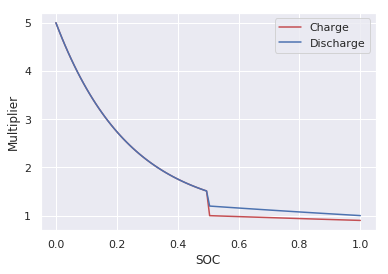





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           180         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 60)           1860        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            61          dense_2[0][0]                    
________________________________________________________________________________________

In [0]:
battery = Battery(scaler_energy = sc_energy, 
                  scaler_price = sc_price)

agent = A2CAgent(state_size, action_size)

**A2C Training**

In [0]:
directory = "/content/drive/My Drive/Colab/Research - Transactive Energy/Case Study 2.6"

In [0]:
total_reward_bef = -10e8
total_reward_list = []

for e in range(0, episodes, 1):

  total_reward = 0
  SOC = np.array([battery.initial_SOC])
  historical_price = np.zeros(timesteps)
  day = 0
  hour = 0
  timestep = 0
  done = False
  
  while day < len(x) / 24:

    # Keep track of the past 24 hours' electricity price
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)

    # Select action based on stochastic policy (Gaussian)
    action = agent.get_action(state)
    next_SOC, reward = battery.compute(state, action)

    if hour < 23:
      hour += 1
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      historical_price[timestep] = x[day * 24 + hour, 2]        
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      done = True
      day += 1
      hour = 0
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      if day < len(x) / 24:
        historical_price[timestep] = x[day * 24 + hour, 2]
        average_price = np.mean(np.array([price for price in historical_price if price != 0]))
        next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
      else:
        break
    
    # Training of actor and critic model
    agent.train_model(state, action, reward, next_state, done)

    SOC = next_SOC 
    total_reward += reward
    done = False
    
  total_reward_list.append(total_reward)
  if total_reward > total_reward_bef:
    total_reward_bef = total_reward
    drive.mount('/content/drive/')
    agent.actor.save_weights(directory + " Actor.hdf5")
    agent.critic.save_weights(directory + " Critic.hdf5")

  with open (directory, "wb") as file:
    pickle.dump(total_reward_list, file)
  
  print("Episode: {}, total_reward: {}".format(e, total_reward))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode: 0, total_reward: [-15264.63513307]
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode: 1, total_reward: [-1578.35739916]
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode: 2, total_reward: [-1178.3830165]
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode: 3, total_reward: [-673.76323523]
Episode: 4, total_reward: [-1668.4309378]
Episode: 5, total_reward: [-674.50473061]
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode: 6, total_reward: [-105.28519104]
Episode: 7, total_reward: [-483.43802809]
Episod

KeyboardInterrupt: ignored

In [0]:
for e in range(50, 200, 1):

  total_reward = 0
  SOC = np.array([battery.initial_SOC])
  historical_price = np.zeros(timesteps)
  day = 0
  hour = 0
  timestep = 0
  done = False
  
  while day < len(x) / 24:

    # Keep track of the past 24 hours' electricity price
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)

    # Select action based on stochastic policy (Gaussian)
    action = agent.get_action(state)
    next_SOC, reward = battery.compute(state, action)

    if hour < 23:
      hour += 1
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      historical_price[timestep] = x[day * 24 + hour, 2]        
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      done = True
      day += 1
      hour = 0
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      if day < len(x) / 24:
        historical_price[timestep] = x[day * 24 + hour, 2]
        average_price = np.mean(np.array([price for price in historical_price if price != 0]))
        next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
      else:
        break
    
    # Training of actor and critic model
    agent.train_model(state, action, reward, next_state, done)

    SOC = next_SOC 
    total_reward += reward
    done = False
    
  total_reward_list.append(total_reward)
  if total_reward > total_reward_bef:
    total_reward_bef = total_reward
    drive.mount('/content/drive/')
    agent.actor.save_weights(directory + " Actor.hdf5")
    agent.critic.save_weights(directory + " Critic.hdf5")

  with open (directory, "wb") as file:
    pickle.dump(total_reward_list, file)
  
  print("Episode: {}, total_reward: {}".format(e, total_reward))

Episode: 30, total_reward: [-417.28526474]
Episode: 31, total_reward: [-311.32302463]
Episode: 32, total_reward: [-457.75495683]
Episode: 33, total_reward: [-563.26664566]
Episode: 34, total_reward: [-328.97306281]
Episode: 35, total_reward: [-1050.43488104]
Episode: 36, total_reward: [-1114.71716633]
Episode: 37, total_reward: [-315.87482358]
Episode: 38, total_reward: [-253.45640878]
Episode: 39, total_reward: [-245.43902097]
Episode: 40, total_reward: [-459.44917747]
Episode: 41, total_reward: [-522.0949751]
Episode: 42, total_reward: [-385.31123363]
Episode: 43, total_reward: [-359.18652157]
Episode: 44, total_reward: [-691.24073272]
Episode: 45, total_reward: [-415.44224126]
Episode: 46, total_reward: [-188.58486112]
Episode: 47, total_reward: [-1292.2807889]
Episode: 48, total_reward: [-994.07612416]
Episode: 49, total_reward: [-134.22254401]
Episode: 50, total_reward: [-217.94353223]
Episode: 51, total_reward: [-230.96444144]
Episode: 52, total_reward: [-947.39542508]
Episode: 5

KeyboardInterrupt: ignored

In [0]:
drive.mount('/content/drive/')
with open (directory, "wb") as file:
  pickle.dump(total_reward_list, file)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


NameError: ignored

In [0]:
with open (directory, "rb") as file:
  total_reward_list = pickle.load(file)

plt.plot(np.array(total_reward_list), 'r-o', label = "Gamma = 0.95")
plt.xlabel("Iteration")
plt.ylabel("Total reward")
plt.legend()
plt.show()

# Result

**Testing**

In [0]:
drive.mount('/content/drive/')
agent.actor.load_weights(directory + " Actor.hdf5")
agent.critic.load_weights(directory + " Critic.hdf5")

SOC = np.array([battery.initial_SOC])
historical_price = np.zeros(timesteps)
day = 0
hour = 0
timestep = 0
done = False
SOC_list = []
action_list = []
reward_list = []
av_price_list = []
fault_list = []

while day < len(x) / 24:
  
  historical_price[timestep] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)
  action = agent.get_action(state)
  next_SOC, reward = battery.compute(state, action)
  
  if action > 0:
    if action * battery.P_rated / battery.E_rated + SOC > 1:
      fault_list.append(1)
    else:
      fault_list.append(0)
  else:
    if action * battery.P_rated / battery.E_rated + SOC < 0:
      fault_list.append(1)
    else:
      fault_list.append(0)        
  
  SOC = next_SOC
  SOC_list.append(SOC)
  reward_list.append(reward)
  action_list.append(action)
  av_price_list.append(average_price)  
  
  if hour < 23:
    hour += 1
    timestep += 1
    if timestep >= timesteps:
      timestep = 0    
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    timestep += 1
    if timestep >= timesteps:
      timestep = 0
    if day < len(x) / 24:
      historical_price[timestep] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break
  
print (np.mean(reward_list))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).





0.0034276263416233243


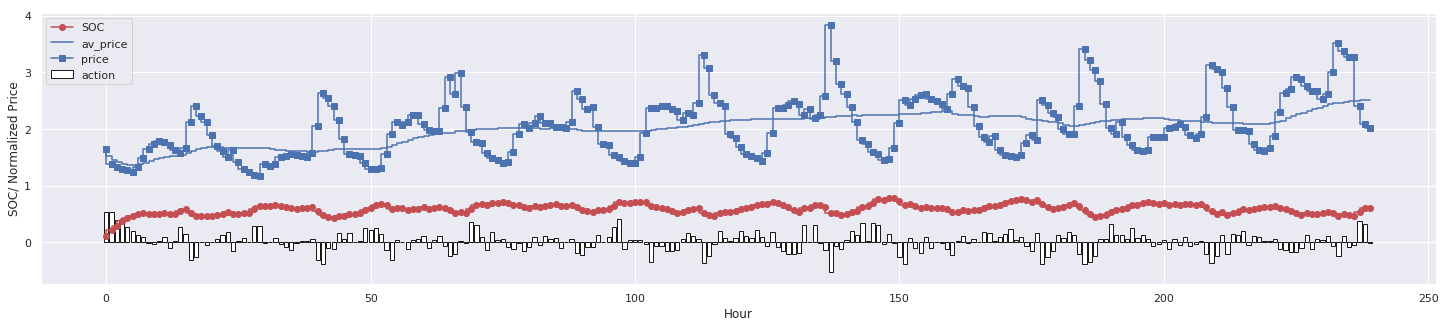

In [0]:
# First 10 days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[0:24 * i], "ro-", label = "SOC")
#plt.step(range(0, 24 * i), x[0:24 * i, 0], "g", label = "pv")
#plt.step(range(0, 24 * i), x[0:24 * i, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[0:24 * i], label = "av_price")
plt.step(range(0, 24 * i), x[0:24 * i, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), action_list[0:24 * i], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

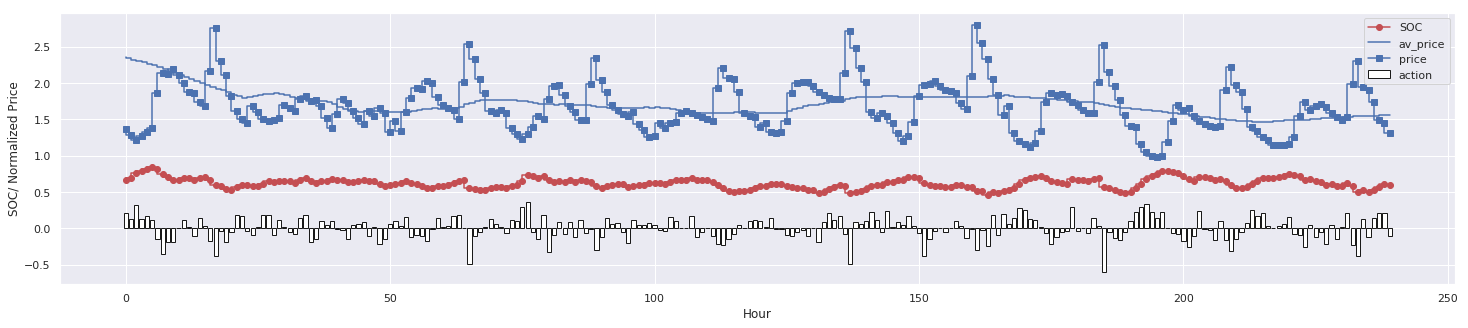

In [0]:
# Second last ten days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[-24 * i * 2:-24 * i], "ro-", label = "SOC")
#plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 0], "g", label = "pv")
#plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[-24 * i * 2:-24 * i], label = "av_price")
plt.step(range(0, 24 * i), x[-24 * i * 2:-24 * i, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), action_list[-24 * i * 2:-24 * i], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

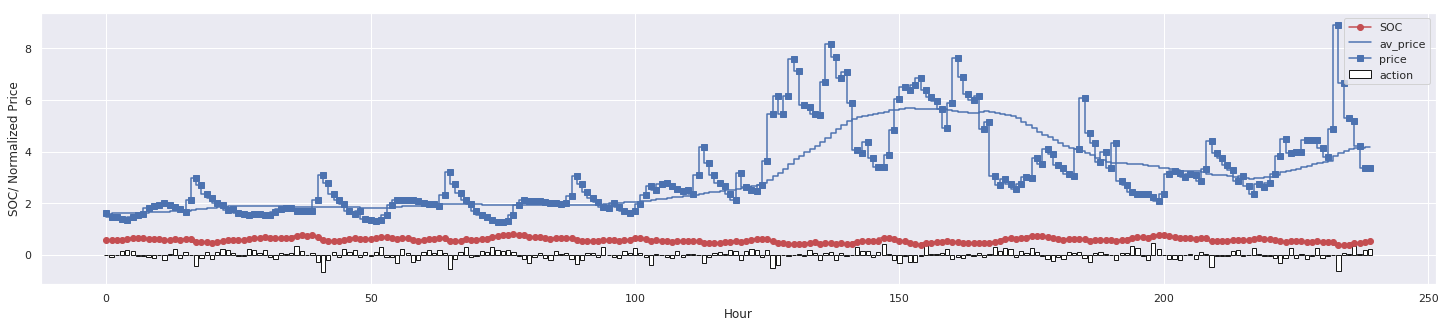

In [0]:
# Last ten days

i = 10

plt.figure(figsize = (25,5))
plt.step(range(0, 24 * i), SOC_list[-24 * i:], "ro-", label = "SOC")
#plt.step(range(0, 24 * i), x[-24 * i:, 0], "g", label = "pv")
#plt.step(range(0, 24 * i), x[-24 * i:, 1], "m", label = "load")
plt.step(range(0, 24 * i), av_price_list[-24 * i:], label = "av_price")
plt.step(range(0, 24 * i), x[-24 * i:, 2], "bs", label = "price")
plt.bar(range(0, 24 * i), action_list[-24 * i:], 
        facecolor = "w", edgecolor = "k", label = "action")
plt.ylabel("SOC/ Normalized Price")
plt.xlabel("Hour")
plt.legend()
plt.show()

In [0]:
SOC_bef_list = SOC_list.copy()
SOC_bef_list.insert(0, 0)
SOC_bef_list = SOC_bef_list[0:-1]

TRC_WOESS = 0
TRC_WESS = 0
OC_WESS = 0

for i in range(0, len(x), 1):
  
  # Without ESS  
  TRC_WOESS = TRC_WOESS - sc_price.inverse_transform(x[i:i+1, 2:3]) \
              * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1])
  TC_WOESS = TRC_WOESS  
  
  # With ESS
  TRC_WESS = TRC_WESS - sc_price.inverse_transform(x[i:i+1, 2:3]) \
             * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1] \
             + np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1))
  OC_WESS = OC_WESS - sc_price.inverse_transform(battery.wear_cost) \
             * sc_energy.inverse_transform(np.abs(np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1)))
  TC_WESS = TRC_WESS + OC_WESS

print ("Cost without ESS: {:0.2f}".format(np.sum(TC_WOESS)))
print ("Cost with ESS: {:0.2f}".format(np.sum(TC_WESS)))
print ("Net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS)))
print ("Daily mean cost without ESS: {:0.2f}".format(np.sum(TC_WOESS / (len(x) / 24))))
print ("Daily mean cost with ESS: {:0.2f}".format(np.sum(TC_WESS / (len(x) / 24))))
print ("Daily net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS) / (len(x) / 24)))

Cost without ESS: -11713917.68
Cost with ESS: -11673685.70
Net benefit: 40231.97
Daily mean cost without ESS: -10836.19
Daily mean cost with ESS: -10798.97
Daily net benefit: 37.22


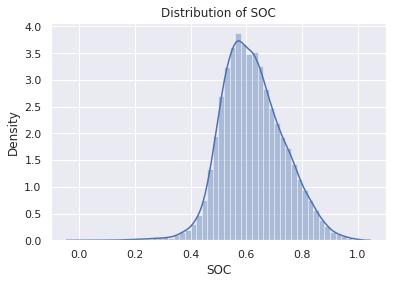

The probability of SOC smaller than target SOC is: 11.09%


In [0]:
sns.distplot(np.array(SOC_list), hist = True, norm_hist = True)
plt.ylabel("Density")
plt.xlabel("SOC")
plt.title("Distribution of SOC")
plt.show()

print("The probability of SOC smaller than target SOC is: {:.2f}%".format(np.sum(np.array(SOC_list) < 0.5) / len(SOC_list) * 100))

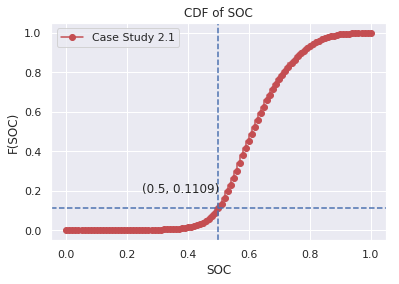

In [0]:
hist, bin_edges = np.histogram(np.array(SOC_list), bins = 100, density = True)
cum_prob = np.hstack((np.array([0]), np.cumsum(hist * np.diff(bin_edges)) / np.sum(hist * np.diff(bin_edges))))
target_SOC = battery.target_SOC
cum_prob_target = cum_prob[np.argmax(bin_edges >= target_SOC)]

plt.step(bin_edges, cum_prob, "r-o", label = "Case Study 2.1")
plt.axvline(x  = target_SOC, linestyle = "--")
plt.axhline(y  = cum_prob_target, linestyle = "--")
plt.annotate("({}, {:.4f})".format(target_SOC, float(cum_prob_target)), 
             xy=(target_SOC - 0.25, cum_prob_target + 0.08))
plt.title("CDF of SOC")
plt.xlabel("SOC")
plt.ylabel("F(SOC)")
plt.legend()
plt.show()

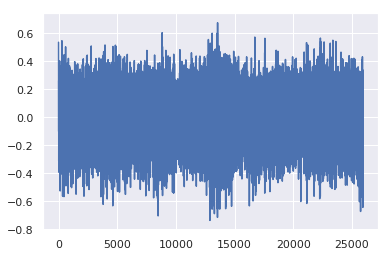

In [0]:
plt.plot(np.array(action_list))

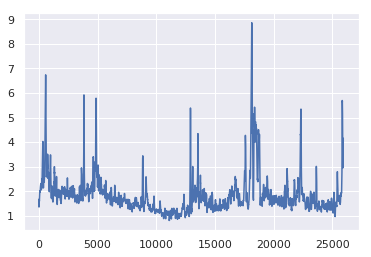

In [0]:
plt.plot(np.array(av_price_list))

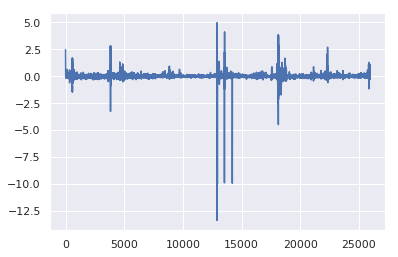

In [0]:
plt.plot(np.array(reward_list))

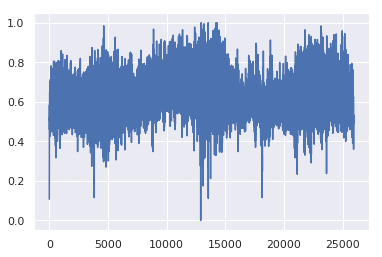

In [0]:
plt.plot(np.array(SOC_list))

In [0]:
sum(np.array(fault_list))

10

In [0]:
np.mean(np.array(SOC_list))

0.6226638194121196

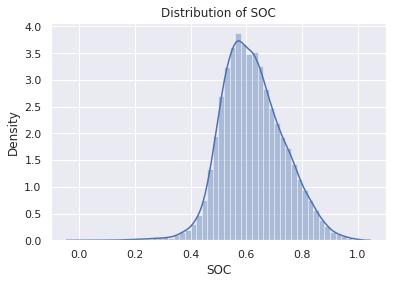

In [0]:
sns.distplot(np.array(SOC_list), hist = True, norm_hist = True)
plt.ylabel("Density")
plt.xlabel("SOC")
plt.title("Distribution of SOC")
plt.show()